In [1]:
%matplotlib inline

import os
import os.path as op
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

Day 4. Voxel-Based Morphometry on MRiShare dataset
============================================

This example uses Voxel-Based Morphometry (VBM) to study the relationship
between aging, sex and gray matter density.

The data come from the MRiShare database, which have been processed with 
SPM12 New Segment VBM pipeline inside ABACI to create VBM maps.


VBM analysis of aging
---------------------

We run a standard GLM analysis to study the association between age
and gray matter density from the VBM data. We use only 100 subjects
from the MRiShare dataset to limit the memory usage.

Note that more power would be obtained from using a larger sample of subjects.



In [3]:
# Authors: Bertrand Thirion, <bertrand.thirion@inria.fr>, July 2018
#          Elvis Dhomatob, <elvis.dohmatob@inria.fr>, Apr. 2014
#          Virgile Fritsch, <virgile.fritsch@inria.fr>, Apr 2014
#          Gael Varoquaux, Apr 2014
# Modified by Ami Tsuchida <atsuch@gmail.com>, July, 2019

Examine MRiShare dataset
------------------



In [2]:
dat_dir= '../data/'
sub_info = pd.read_csv(op.join(dat_dir, 'sample_mrishare_subinfo.csv'), index_col=0)
sub_info.head()

,Sex,Handedness,Age,Score
mrishare_id,,,,
SHARE0001,M,D,24.241,93.732513
SHARE0002,F,D,22.943,125.112598
SHARE0004,M,D,23.107,91.241367
SHARE0006,M,D,22.916,121.776685
SHARE0007,M,D,20.011,103.942988


In [3]:
n_subjects = len(sub_info)
n_subjects

100

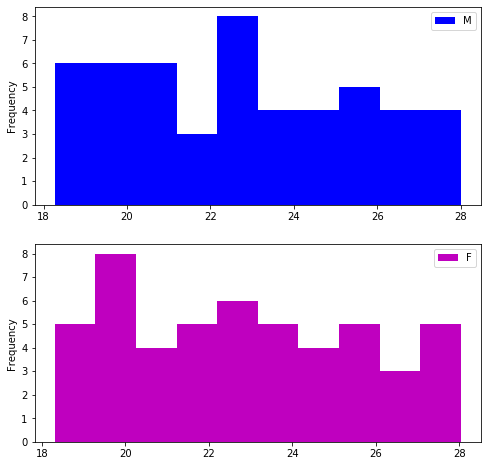

In [4]:
# Check number of subjects and age distribution
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8,8))
sub_info[sub_info.Sex=='M']['Age'].plot.hist(color='b', ax=ax1)
ax1.legend('M')
sub_info[sub_info.Sex=='F']['Age'].plot.hist(color='m', ax=ax2)
ax2.legend('F')

In [5]:
grouped = sub_info.groupby('Sex')
grouped.describe()

Age                                                                 \
    count      mean       std     min     25%      50%       75%     max   
Sex                                                                        
F    50.0  22.86300  2.808525  18.308  20.262  22.9035  25.31075  28.030   
M    50.0  22.77346  2.810946  18.272  20.296  22.8570  25.08700  27.995   

    Score                                                           \
    count        mean        std        min        25%         50%   
Sex                                                                  
F    50.0   97.233923  14.671722  72.523768  87.944829   96.525077   
M    50.0  100.832464  14.128692  70.649083  92.218571  101.402686   

                             
            75%         max  
Sex                          
F    110.221035  125.112598  
M    108.402293  130.525952

In [ ]:
# Get the path to GM map for each subject in the same order as sub_info.csv

gray_matter_map_filenames = []

for sub in sub_info.mrishare_id.values:
    gray_matter_map_file_glob = glob.glob(op.join(mrishare_dat_path, sub, '{}_mwc1NUT1*.nii.gz'))
    if not gray_matter_map_file_glob:
        print ('Could not find the grey matter map for {}!'.format(sub))
    else:
        gray_matter_map_filenames.append(gray_matter_map_file_glob[0])


In [ ]:
# Check to make sure you have expected number of files
len(gray_matter_map_filenames)

In [6]:
age = sub_info.Age.values
age

array([24.241, 22.943, 23.107, 22.916, 20.011, 23.715, 21.426, 23.745,
       20.843, 21.843, 19.825, 26.669, 23.08 , 25.374, 24.583, 21.465,
       20.233, 22.768, 21.065, 22.319, 24.55 , 23.17 , 27.433, 19.973,
       19.458, 22.908, 19.893, 20.509, 19.578, 22.806, 20.887, 24.014,
       25.766, 25.117, 18.815, 20.175, 26.031, 27.995, 22.864, 18.324,
       18.322, 18.762, 24.233, 26.335, 25.112, 27.28 , 18.272, 18.992,
       18.308, 19.529, 21.774, 20.912, 23.652, 26.264, 27.398, 23.088,
       26.064, 22.168, 20.846, 18.782, 26.026, 21.369, 27.258, 19.009,
       25.963, 26.672, 20.523, 22.768, 19.915, 18.847, 26.108, 19.641,
       24.564, 27.422, 22.757, 28.03 , 23.745, 19.789, 21.462, 20.044,
       23.173, 25.966, 23.995, 24.55 , 27.184, 26.292, 21.095, 23.138,
       20.044, 27.42 , 25.821, 25.377, 22.448, 18.94 , 21.807, 25.44 ,
       24.997, 23.636, 19.573, 20.485])

Sex is encoded as 'M' or 'F'. make it a binary variable



In [7]:
sex = sub_info.Sex.values == 'F'
sex

array([False,  True, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False,  True,
       False, False,  True,  True, False, False,  True,  True,  True,
       False, False, False,  True,  True,  True,  True,  True, False,
       False,  True, False,  True,  True,  True, False,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True, False,  True,  True,  True,  True,
        True,  True, False, False,  True,  True, False,  True,  True,
       False])

Print basic information on the dataset



In [7]:
age

array([74., 55., 73., 28., 18., 24., 21., 20., 74., 52.])

In [8]:
sex

array([ True,  True,  True, False, False,  True, False,  True, False,
        True])

Get a mask image: We placed a brain mask image in the template space in a folder 'template' under mrishare_dat_path.

Take a look at this mask using the plotting function from nilearn.


In [ ]:
mask = op.join(mrishare_dat_path, 'template', 'brainmask.nii.gz')
template = op.join(mrishare_dat_path, 'template', 'SHARE_T1.nii.gz')

In [ ]:
from nilearn import plotting
display = plotting.plot_roi(mask, template)

Analyse data
------------

First create an adequate design matrix with three columns: 'age',
'sex', 'intercept'.



In [10]:
intercept = np.ones(n_subjects)
design_matrix = pd.DataFrame(np.vstack((sex, age, intercept)).T,
                             columns=['sex', 'age', 'intercept'])

Plot the design matrix



Text(30.25, 0.5, 'maps')

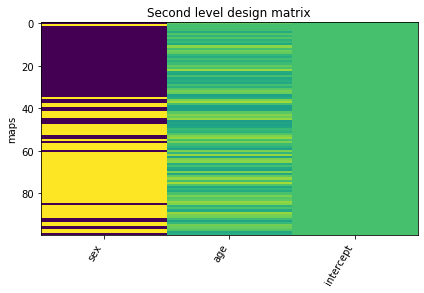

In [11]:
from nistats.reporting import plot_design_matrix
ax = plot_design_matrix(design_matrix)
ax.set_title('Second level design matrix', fontsize=12)
ax.set_ylabel('maps')

In [12]:
design_matrix.head()

,sex,age,intercept
0,0.0,24.241,1.0
1,1.0,22.943,1.0
2,0.0,23.107,1.0
3,0.0,22.916,1.0
4,0.0,20.011,1.0


Specify and fit the second-level model when loading the data, we
smooth a little bit to improve statistical behavior



In [ ]:
from nistats.second_level_model import SecondLevelModel
second_level_model = SecondLevelModel(smoothing_fwhm=2.0, mask=mask_img)
second_level_model.fit(gray_matter_map_filenames,
                       design_matrix=design_matrix)

Estimate the contrast is very simple. We can just provide the column
name of the design matrix.



In [ ]:
z_map = second_level_model.compute_contrast(second_level_contrast=[1, 0, 0],
                                            output_type='z_score')

We threshold the second level contrast at uncorrected p < 0.001 and plot it.
First compute the threshold.



In [ ]:
from nistats.thresholding import map_threshold
_, threshold = map_threshold(
    z_map, level=.05, height_control='fdr')
print('The FDR=.05-corrected threshold is: %.3g' % threshold)

The plot it



In [ ]:
from nilearn import plotting
display = plotting.plot_stat_map(
    z_map, threshold=threshold, colorbar=True, display_mode='z',
    cut_coords=[-4, 26],
    title='age effect on grey matter density (FDR = .05)')
plotting.show()

Can also study the effect of sex: compute the stat, compute the
threshold, plot the map



In [ ]:
z_map = second_level_model.compute_contrast(second_level_contrast='sex',
                                            output_type='z_score')
_, threshold = map_threshold(
    z_map, level=.05, height_control='fdr')
plotting.plot_stat_map(
    z_map, threshold=threshold, colorbar=True,
    title='sex effect on grey matter density (FDR = .05)')

Note that there does not seem to be any significant effect of sex on
grey matter density on that dataset.



## Exercise 1

In the model tested above, we tested the simplest model that assumed no interaction between Age and Sex.

This is not wrong, as long as you have no reason or interest to believe in the possibility of Age x Sex.

How could you modify the design matrix to test the interaction between Age and Sex?

Here are some useful resources if you are not sure;

* GLM and design matirx: background
stat_modeling.pdf
glm.pdf
(under resources folder)

* Design matrix and mean-centering
http://mumford.fmripower.org/mean_centering/

* Other examples of GLM and design matrices
https://fsl.fmrib.ox.ac.uk/fsl/fslwiki/GLM



## Exercise 2

In the sub_info.csv, there is a column 'Score', representing a cognitive test score.
Can you create a new design matrix and contrast to investigate the effect of cognitive score, 
after controlling for age and sex?

## Exercise 3

We used nistats and nilearn to perform the simple GLM analyses and view the results. However, you can use more conventional software packages (FSL, SPM, AFNI, etc) to perform the same analyses. They differ in how you specify desgin matrices/contrasts, how you can control for the multiple comparisons.

Because VBM is typically performed using SPM VBM pipeline, many use SPM for GLM as well. But you don't have to! You should choose the tools based on the features (eg. options for multiple comparison corrections) you desire.

Try using SPM or FSL to perform the same analysis you tried above.